<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week5/GRU_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.utils import plot_model

In [21]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [22]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


### 1. DATA PREPARATION


In [23]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
df = pd.read_csv(url)
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [24]:
# Rename the unnamed column properly
df = df.rename(columns={'Unnamed: 0': 'Index'})


In [25]:
# Basic data cleaning
df['Review Text'] = df['Review Text'].fillna('')  # Fill NaN values
df['Title'] = df['Title'].fillna('')  # Fill NaN values

# Combine title and review text for a more comprehensive analysis
df['Full_Text'] = df['Title'] + ' ' + df['Review Text']

# Clean the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

df['Full_Text'] = df['Full_Text'].apply(clean_text)


In [26]:
# Target variable: we'll use "Recommended IND" as our binary classification target
# 1 means the product is recommended, 0 means not recommended
y = df['Recommended IND'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['Full_Text'].values, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 18788
Testing samples: 4698


### 2. TENSORFLOW DATA PREPARATION


In [27]:
# Using Universal Sentence Encoder from TF Hub
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [28]:
# Function to convert text to embeddings using USE
def embed_text(texts):
    return use_embed(texts).numpy()


In [29]:
# Create embeddings for train and test data
# Note: For large datasets, you might want to batch this process
print("Creating embeddings for training data...")
X_train_embedded = embed_text(X_train)
print("Creating embeddings for test data...")
X_test_embedded = embed_text(X_test)

print(f"Embedding shape: {X_train_embedded.shape}")  # Should be (num_samples, 512)


Creating embeddings for training data...
Creating embeddings for test data...
Embedding shape: (18788, 512)


In [30]:
# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_embedded, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_embedded, y_test))


In [31]:
# Calculate class weights for imbalanced data
total_samples = len(y_train)
n_positive = sum(y_train)
n_negative = total_samples - n_positive


In [32]:
# Formula: class_weight = total_samples / (n_classes * samples_per_class)
class_weight = {
    0: total_samples / (2 * n_negative),
    1: total_samples / (2 * n_positive)
}

print(f"Class weights: {class_weight}")


Class weights: {0: np.float64(2.8151033862750974), 1: np.float64(0.6079865380881496)}


In [33]:
# Batch and prefetch data for performance
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### 3. TENSORFLOW MODEL DEFINITION


In [34]:
def build_classifier_model():
    # Input layer for preprocessed embeddings (512 dimensions from USE)
    input_layer = Input(shape=(512,), dtype=tf.float32)

    # First hidden layer with dropout
    # Formula: h1 = ReLU(W1*x + b1)
    # ReLU(z) = max(0, z)
    x = Dense(256, activation='relu')(input_layer)

    # Dropout for regularization
    # Formula: dropout(x) = 0 with probability p, x/(1-p) with probability (1-p)
    x = Dropout(0.2)(x)

    # Second hidden layer with dropout
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer for binary classification
    # Formula: y = sigmoid(W3*x + b3)
    # sigmoid(z) = 1/(1 + e^(-z)) transforms output to probability between 0 and 1
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model


In [35]:
# Create and compile the model
model = build_classifier_model()

In [36]:
# Formula: Binary Cross-Entropy Loss = -(y * log(p) + (1-y) * log(1-p))
# where y is the true label and p is the predicted probability
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

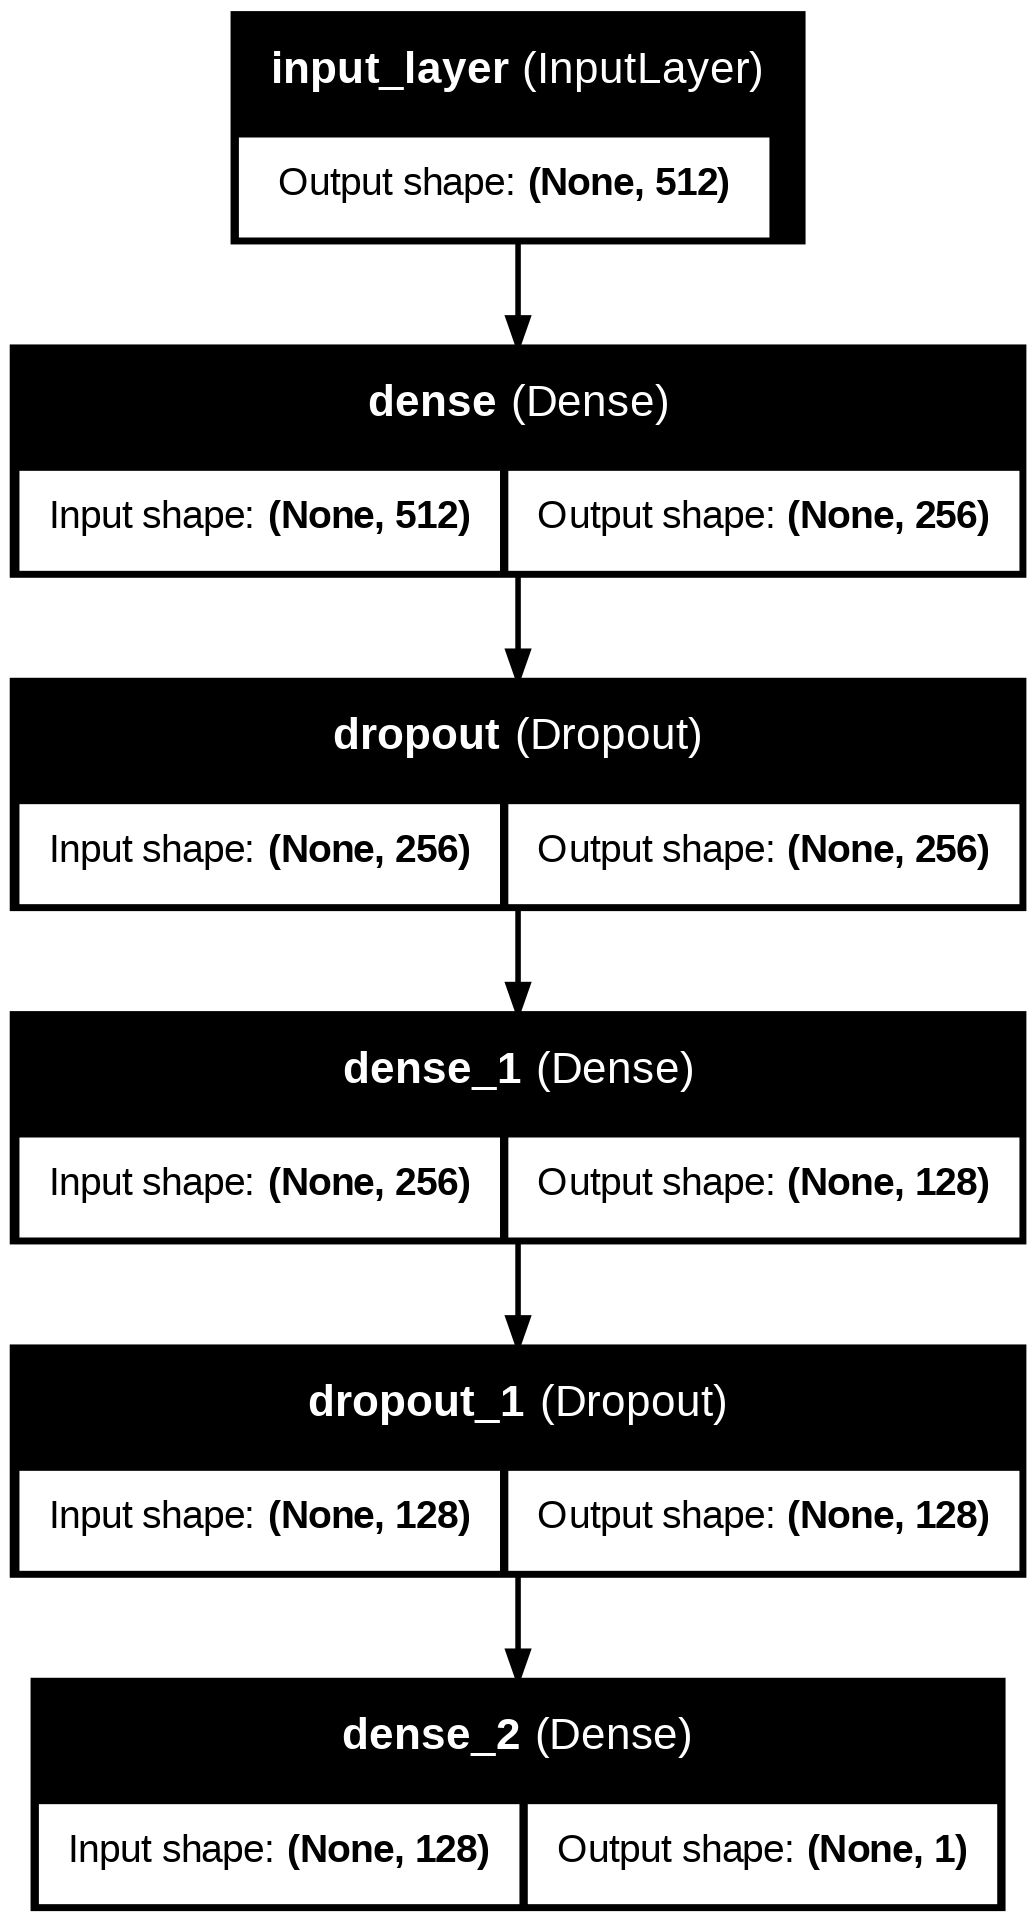

In [37]:
# Visualize model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='tensorflow_model.png')


### 4. TRAINING THE MODEL


In [39]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_clothing_classifier_tensorflow.h5',
    monitor='val_accuracy',
    save_best_only=True
)

# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weight
)


Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - auc: 0.9441 - loss: 0.3007 - precision: 0.9708 - recall: 0.8648

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8678 - auc: 0.9441 - loss: 0.3007 - precision: 0.9708 - recall: 0.8648 - val_accuracy: 0.8421 - val_auc: 0.9344 - val_loss: 0.3648 - val_precision: 0.9722 - val_recall: 0.8317
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8620 - auc: 0.9443 - loss: 0.3000 - precision: 0.9742 - recall: 0.8543 - val_accuracy: 0.8416 - val_auc: 0.9350 - val_loss: 0.3690 - val_precision: 0.9736 - val_recall: 0.8299
Epoch 3/10
576/588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - auc: 0.9459 - loss: 0.2961 - precision: 0.9752 - recall: 0.8557

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8640 - auc: 0.9460 - loss: 0.2959 - precision: 0.9752 - recall: 0.8558 - val_accuracy: 0.8446 - val_auc: 0.9351 - val_loss: 0.3591 - val_precision: 0.9717 - val_recall: 0.8354
Epoch 4/10
583/588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8652 - auc: 0.9461 - loss: 0.2945 - precision: 0.9745 - recall: 0.8579

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8652 - auc: 0.9461 - loss: 0.2944 - precision: 0.9745 - recall: 0.8580 - val_accuracy: 0.8474 - val_auc: 0.9355 - val_loss: 0.3515 - val_precision: 0.9712 - val_recall: 0.8392
Epoch 5/10
573/588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - auc: 0.9481 - loss: 0.2886 - precision: 0.9757 - recall: 0.8605

588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8682 - auc: 0.9481 - loss: 0.2885 - precision: 0.9757 - recall: 0.8606 - val_accuracy: 0.8478 - val_auc: 0.9355 - val_loss: 0.3505 - val_precision: 0.9710 - val_recall: 0.8400
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8704 - auc: 0.9491 - loss: 0.2858 - precision: 0.9765 - recall: 0.8626 - val_accuracy: 0.8474 - val_auc: 0.9355 - val_loss: 0.3521 - val_precision: 0.9718 - val_recall: 0.8387
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8733 - auc: 0.9514 - loss: 0.2791 - precision: 0.9767 - recall: 0.8661 - val_accuracy: 0.8472 - val_auc: 0.9359 - val_loss: 0.3549 - val_precision: 0.9721 - val_recall: 0.8382
Epoch 8/10
580/588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - auc: 0.9511 - loss: 0.2800 - precision: 0.9765 - recall: 0.8628

588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8706 - auc: 0.9511 - loss: 0.2799 - precision: 0.9765 - recall: 0.8629 - val_accuracy: 0.8499 - val_auc: 0.9354 - val_loss: 0.3523 - val_precision: 0.9722 - val_recall: 0.8416


### 5. EVALUATION AND VISUALIZATION


In [40]:
# Load the best model
model = tf.keras.models.load_model('best_clothing_classifier_tensorflow.h5')


In [41]:
# Predict on test data
y_pred_prob = model.predict(X_test_embedded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [42]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\nFINAL EVALUATION METRICS (TENSORFLOW):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")



FINAL EVALUATION METRICS (TENSORFLOW):
Accuracy: 0.8499
Precision: 0.9722
Recall: 0.8416
F1 Score: 0.9022
AUC-ROC: 0.9354


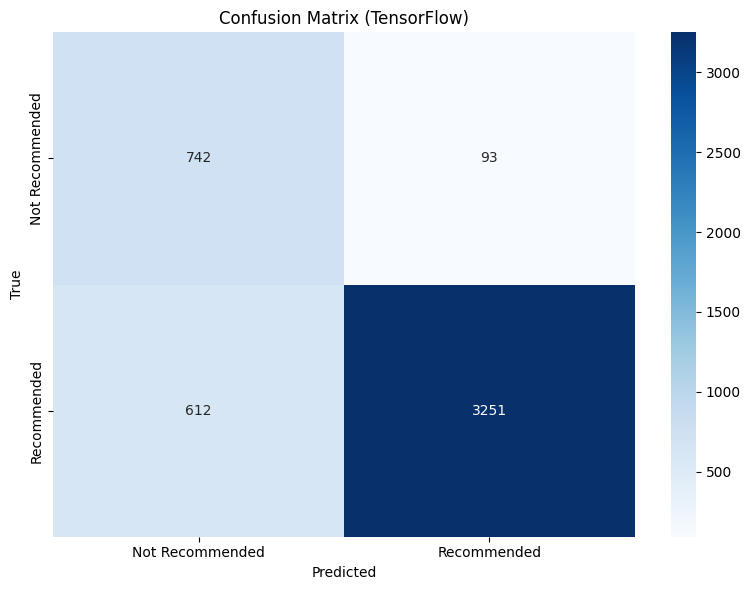

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'],
           yticklabels=['Not Recommended', 'Recommended'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (TensorFlow)')
plt.tight_layout()
plt.savefig('tensorflow_confusion_matrix.png')
plt.show()


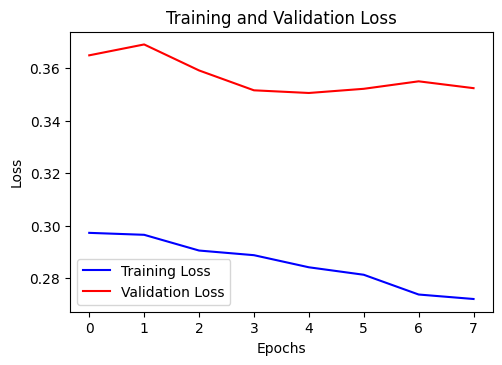

In [45]:
# Plot training history
plt.figure(figsize=(12, 8))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


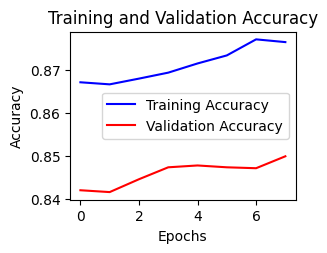

In [46]:
# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


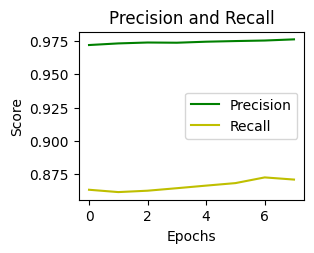

In [47]:
# Precision and Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], 'g-', label='Precision')
plt.plot(history.history['recall'], 'y-', label='Recall')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()


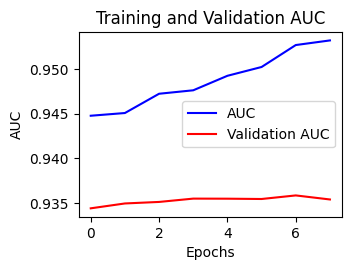

In [48]:
# AUC plot
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], 'b-', label='AUC')
plt.plot(history.history['val_auc'], 'r-', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.savefig('tensorflow_metrics.png')
plt.show()


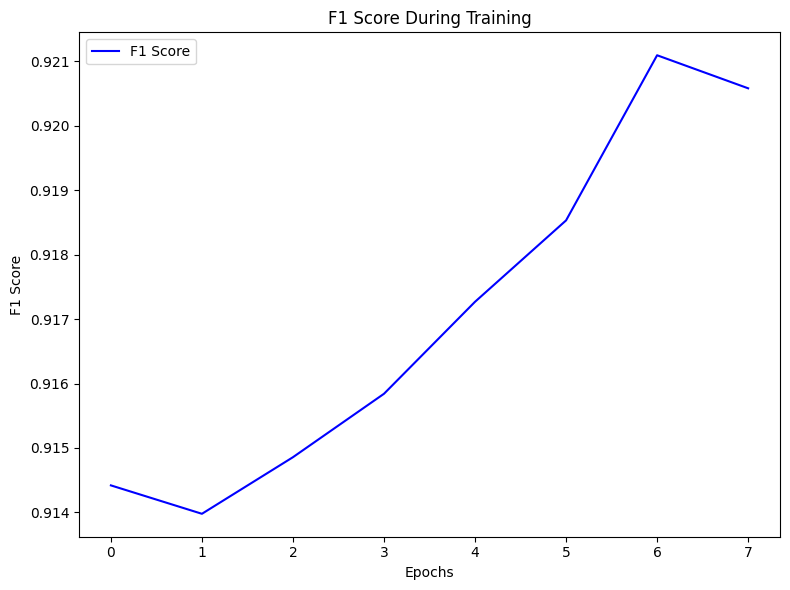


TensorFlow model training and evaluation complete!


In [49]:
# Calculate F1 Score manually since Keras doesn't track it
def calculate_f1(precision, recall):
    # Formula: F1 = 2 * (precision * recall) / (precision + recall)
    return 2 * (precision * recall) / (precision + recall + 1e-10)

# Calculate F1 scores from precision and recall history
train_f1 = calculate_f1(
    np.array(history.history['precision']),
    np.array(history.history['recall'])
)
plt.figure(figsize=(8, 6))
plt.plot(train_f1, 'b-', label='F1 Score')
plt.title('F1 Score During Training')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('tensorflow_f1.png')
plt.show()

print("\nTensorFlow model training and evaluation complete!")


### 6. MATHEMATICAL EXPLANATIONS FOR THE METRICS

#### MATHEMATICAL EXPLANATIONS FOR EVALUATION METRICS:

1. **Accuracy**:
   - Formula: (TP + TN) / (TP + TN + FP + FN)
   - Explanation: The proportion of all correct predictions out of all predictions.
   - Where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives.

2. **Precision**:
   - Formula: TP / (TP + FP)
   - Explanation: The proportion of correct positive predictions out of all positive predictions.
   - Indicates how reliable the positive predictions are.

3. **Recall (Sensitivity)**:
   - Formula: TP / (TP + FN)
   - Explanation: The proportion of actual positives that were correctly identified.
   - Indicates how well the model finds all positive cases.

4. **F1 Score**:
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Explanation: The harmonic mean of precision and recall.
   - Balances precision and recall in a single metric.

5. **AUC-ROC**:
   - Formula: Area Under the Receiver Operating Characteristic Curve
   - Explanation: Measures the model's ability to discriminate between classes.
   - An AUC of 1.0 means perfect discrimination, 0.5 means random guessing.

6. **Binary Cross-Entropy Loss**:
   - Formula: -(y * log(p) + (1-y) * log(1-p))
   - Explanation: Measures how well the predicted probabilities match the actual labels.
   - A lower value indicates better model performance.

7. **ReLU Activation**:
   - Formula: f(x) = max(0, x)
   - Explanation: Introduces non-linearity to the model, allowing it to learn complex patterns.
   - Helps prevent the vanishing gradient problem.

8. **Sigmoid Activation**:
   - Formula: σ(x) = 1 / (1 + e^(-x))
   - Explanation: Transforms any input into a value between 0 and 1.
   - Used in the output layer for binary classification to represent probability.


### FINAL EVALUATION METRICS (TENSORFLOW):
- **Accuracy**: 0.8499
- **Precision**: 0.9722
- **Recall**: 0.8416
- **F1 Score**: 0.9022
- **AUC-ROC**: 0.9354